In [17]:
from dotenv import load_dotenv
from rich import print as rich_print
from __future__ import annotations


from dataclasses import dataclass, field
from pydantic import BaseModel
from typing import List, Optional
from pydantic_ai import Agent, NativeOutput

from pydantic_graph import BaseNode, End, Graph, GraphRunContext

load_dotenv()


True

In [18]:
import ollama
from pydantic_ai.models.openai import OpenAIChatModel
from pydantic_ai.providers.ollama import OllamaProvider


OLLAMA_MODEL_NAME = "gpt-oss:20b"
OLLAMA_BASE_URL = "http://localhost:11434"
ollama.pull(OLLAMA_MODEL_NAME)
model = OpenAIChatModel(
    model_name=OLLAMA_MODEL_NAME,
    provider=OllamaProvider(base_url=f"{OLLAMA_BASE_URL}/v1", api_key="ollama"),
)

In [19]:
import os
from tavily import TavilyClient

tavily_client = TavilyClient(api_key=os.environ.get('TAVILY_API_KEY'))

with open("GEORGE_WASHINGTON_RESUME.md", "r", encoding="utf-8") as f:
    resume_text = f.read()

In [20]:
class JobPosting(BaseModel):
    title: str
    description: str
    url: str
    analyzed: bool = False
    is_good_fit: bool = False
    fit_reasoning: Optional[str] = None

# Structured output types for agents
class JobAnalysisResult(BaseModel):
    """Result of analyzing a job posting for candidate fit."""
    should_skip: bool  # True if this is not an individual job posting
    is_good_fit: bool  # True if candidate is a good fit
    reasoning: str  # Explanation of the decision

class RefinedQuery(BaseModel):
    """A refined search query for finding job postings."""
    search_query: str  # The refined search query

@dataclass
class State:
    job_postings: List[JobPosting] = field(default_factory=list)
    search_query: str = "executive leadership government defense jobs"
    search_iteration: int = 0
    max_search_iterations: int = 3
    candidate_resume: str = resume_text  # Use the loaded text directly
    good_fit_jobs: List[JobPosting] = field(default_factory=list)
    final_summaries: List[str] = field(default_factory=list)


In [21]:
# OutputProcessor Node: Generates summaries for good fit jobs
summary_agent = Agent(model)

@dataclass
class OutputProcessor(BaseNode[State]):
    """Takes all the job postings which the candidate would be good for, and writes a summary describing the job, and how the candidate should position themselves for the job, including the original link."""
    
    async def run(self, ctx: GraphRunContext[State]) -> End[None]:
        state = ctx.state
        
        if not state.good_fit_jobs:
            rich_print("[yellow]Output Processor:[/yellow] No good fit jobs found. Generating summary anyway.")
            state.final_summaries.append("No suitable job postings were found that match the candidate's profile.")
            return End(None)
        
        rich_print(f"[blue]Output Processor:[/blue] Generating summaries for {len(state.good_fit_jobs)} good fit jobs...")
        
        for job in state.good_fit_jobs:
            try:
                # Fetch full job content for better summary
                try:
                    extract_response = tavily_client.extract(job.url)
                    full_content = extract_response.get('content', job.description)
                except:
                    full_content = job.description
                
                summary_prompt = f"""Create a comprehensive summary for this job posting and provide guidance on how the candidate should position themselves.

Job Posting:
Title: {job.title}
URL: {job.url}
Description: {full_content[:3000]}

Candidate Resume:
{state.candidate_resume[:2000]}

Fit Reasoning: {job.fit_reasoning}

Create a summary that includes:
1. A clear description of the job role and responsibilities
2. Key requirements and qualifications
3. How the candidate's experience aligns with this role
4. Specific recommendations on how the candidate should position themselves in their application
5. The original job posting URL

Format the output in a clear, professional manner suitable for a job application guide."""
                
                result = await summary_agent.run(summary_prompt)
                summary = result.output
                state.final_summaries.append(summary)
                
                rich_print(f"[green]Output Processor:[/green] ✓ Generated summary for {job.title}")
                
            except Exception as e:
                rich_print(f"[red]Output Processor Error for {job.title}:[/red] {e}")
                # Create a basic summary even if agent fails
                basic_summary = f"""**{job.title}**

{job.description[:500]}

**Original Link:** {job.url}

**Fit Reasoning:** {job.fit_reasoning}

**Positioning Advice:** The candidate should emphasize their leadership experience, strategic thinking, and institutional building capabilities when applying for this role.
"""
                state.final_summaries.append(basic_summary)
        
        return End(None)


In [22]:
# Analyzer Node: Determines if job postings are a good fit for the candidate
analyzer_agent = Agent[None, JobAnalysisResult](
    model,
    output_type=NativeOutput(
        JobAnalysisResult,
        name='JobAnalysisResult',
        description='Analysis result determining if a job posting is a good fit for the candidate',
    ),
)

@dataclass
class Analyzer(BaseNode[State]):
    """Fetches the contents of a job posting using tavily, then determines whether the candidate is a good fit. Skips search results which are not individual job postings."""
    
    async def run(self, ctx: GraphRunContext[State]) -> 'Orchestrator | OutputProcessor':
        state = ctx.state
        
        # Get unanalyzed job postings
        unanalyzed = [job for job in state.job_postings if not job.analyzed]
        
        if not unanalyzed:
            rich_print(f"[yellow]Analyzer:[/yellow] No unanalyzed job postings. Moving to output processor.")
            return OutputProcessor()
        
        rich_print(f"[magenta]Analyzer:[/magenta] Analyzing {len(unanalyzed)} job postings...")
        
        for job in unanalyzed:
            try:
                # Fetch full content using Tavily extract
                try:
                    extract_response = tavily_client.extract(job.url)
                    full_content = extract_response.get('content', job.description)
                except:
                    # If extract fails, use the description we already have
                    full_content = job.description
                
                # Use agent to analyze if candidate is a good fit
                analysis_prompt = f"""Analyze this job posting and determine if the candidate is a good fit.

Job Posting:
Title: {job.title}
URL: {job.url}
Description: {full_content[:2000]}

Candidate Resume:
{state.candidate_resume[:2000]}

Determine if this is:
1. A legitimate individual job posting (not a job board listing page or category page)
2. A good fit for the candidate based on their experience and skills

Set should_skip to true if this is not an individual job posting.
Set is_good_fit to true if the candidate is a good fit, false otherwise.
Provide clear reasoning for your decision."""
                
                result = await analyzer_agent.run(analysis_prompt)
                analysis = result.output
                
                job.analyzed = True
                
                if analysis.should_skip:
                    rich_print(f"[dim]Analyzer:[/dim] Skipping {job.title} (not an individual job posting)")
                    continue
                
                job.is_good_fit = analysis.is_good_fit
                job.fit_reasoning = analysis.reasoning
                
                if analysis.is_good_fit:
                    state.good_fit_jobs.append(job)
                    rich_print(f"[green]Analyzer:[/green] ✓ Good fit: {job.title}")
                else:
                    rich_print(f"[dim]Analyzer:[/dim] ✗ Not a fit: {job.title}")
                    
            except Exception as e:
                rich_print(f"[red]Analyzer Error for {job.title}:[/red] {e}")
                job.analyzed = True  # Mark as analyzed to avoid infinite loop
        
        rich_print(f"[magenta]Analyzer:[/magenta] Found {len(state.good_fit_jobs)} good fit jobs out of {len([j for j in state.job_postings if j.analyzed])} analyzed.")
        
        # Check if we should search for more jobs
        if len(state.good_fit_jobs) < 3 and state.search_iteration < state.max_search_iterations:
            return Orchestrator()
        else:
            return OutputProcessor()


In [23]:
# Searcher Node: Searches for job postings and refines search queries
orchestrator_agent = Agent[None, RefinedQuery](
    model,
    output_type=NativeOutput(
        RefinedQuery,
        name='RefinedQuery',
        description='A refined search query for finding job postings',
    ),
)

@dataclass
class Searcher(BaseNode[State]):
    """Calls the tavily search tool to find new job postings, and tweaks the search query based on recent job postings."""
    
    async def run(self, ctx: GraphRunContext[State]) -> 'Orchestrator':
        state = ctx.state
        
        # Update search iteration
        state.search_iteration += 1
        
        # Use the agent to potentially refine the search query based on recent results
        if state.job_postings:
            recent_titles = [job.title for job in state.job_postings[-5:]]
            prompt = f"""Based on these recent job posting titles we found: {', '.join(recent_titles)}
        Suggest a refined search query to find similar but different job postings. 
        Current query: {state.search_query}
        Provide a new refined search query."""
            
            result = await orchestrator_agent.run(prompt)
            refined_query = result.output
            state.search_query = refined_query.search_query
            rich_print(f"[cyan]Searcher:[/cyan] Refined query to: {state.search_query}")
        else:
            rich_print(f"[cyan]Searcher:[/cyan] Using initial query: {state.search_query}")
        
        # Search for job postings using Tavily
        search_response = tavily_client.search(
            query=state.search_query,
            search_depth="advanced",
            max_results=10,
            include_domains=["indeed.com", "linkedin.com", "glassdoor.com", "monster.com", "ziprecruiter.com"]
        )
        
        # Extract job postings from search results
        new_jobs = []
        existing_urls = {job.url for job in state.job_postings}
        
        for result in search_response.get('results', []):
            url = result.get('url', '')
            title = result.get('title', '')
            content = result.get('content', '')
            
            # Skip if we already have this URL
            if url in existing_urls:
                continue
            
            # Only add if it looks like a job posting (basic heuristic)
            if any(keyword in title.lower() or keyword in content.lower() 
                   for keyword in ['job', 'position', 'role', 'career', 'hiring', 'apply']):
                new_jobs.append(JobPosting(
                    title=title,
                    description=content[:500] if content else title,  # Truncate description
                    url=url
                ))
        
        state.job_postings.extend(new_jobs)
        rich_print(f"[green]Searcher:[/green] Found {len(new_jobs)} new job postings. Total: {len(state.job_postings)}")
        
        return Orchestrator()


In [24]:
@dataclass
class Orchestrator(BaseNode[State]):
    """Examines the current state and determines the next best action to take."""
    
    async def run(self, ctx: GraphRunContext[State]) -> Searcher | Analyzer:
        state = ctx.state
        
        # Check if we've done enough searches
        if state.search_iteration >= state.max_search_iterations:
            rich_print(f"[yellow]Orchestrator:[/yellow] Max search iterations reached. Moving to analyzer.")
            return Analyzer()
        
        # Check if we have unanalyzed job postings
        unanalyzed = [job for job in state.job_postings if not job.analyzed]
        if unanalyzed:
            rich_print(f"[yellow]Orchestrator:[/yellow] Found {len(unanalyzed)} unanalyzed job postings. Moving to analyzer.")
            return Analyzer()
        
        # Otherwise, search for more jobs
        rich_print(f"[yellow]Orchestrator:[/yellow] Need more job postings. Moving to searcher (iteration {state.search_iteration + 1}).")
        return Searcher()


In [25]:
# Create the graph with all nodes
job_search_graph = Graph(
    nodes=[Orchestrator, Searcher, Analyzer, OutputProcessor],
    state_type=State
)

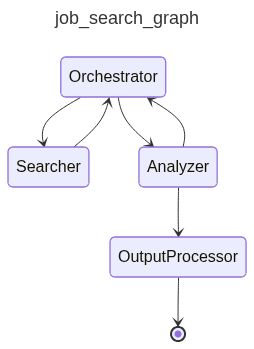

In [26]:
from PIL import Image
from io import BytesIO
import IPython.display

img_bytes = job_search_graph.mermaid_image()
if isinstance(img_bytes, bytes):
    img = Image.open(BytesIO(img_bytes))
    IPython.display.display(img)
else:
    rich_print("[red]Could not display image: Output was not raw image bytes.[/red]")

In [27]:
async def run_job_search():
    initial_state = State()
    rich_print("[bold]Starting job search graph...[/bold]")
    
    result = await job_search_graph.run(Orchestrator(), state=initial_state)
    
    final_state = result.state
    rich_print(f"\n[bold green]Job search complete![/bold green]")
    rich_print(f"Found {len(final_state.good_fit_jobs)} good fit jobs out of {len(final_state.job_postings)} total job postings.\n")
    
    # Display summaries
    for i, summary in enumerate(final_state.final_summaries, 1):
        rich_print(f"[bold]Summary {i}:[/bold]")
        rich_print(summary)
        rich_print("\n" + "="*80 + "\n")
    
    return final_state


In [28]:
# uncomment this to run the job search
#result_state = await run_job_search()